<a href="https://colab.research.google.com/github/yinghong7/PySP/blob/master/Vibration_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import librosa
import keras
from sklearn.preprocessing import Normalizer, LabelBinarizer, OneHotEncoder
from keras.layers import Input, Dropout, Dense, LSTM, Softmax
from keras.models import Model
from keras import regularizers
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import sklearn
import graphviz

In [ ]:
filename = 'Vibration_raw.xlsx'
xls = pd.ExcelFile(filename)
folder = ['1726_CH1', '1726_CH2', '1726_CH3', '2049_CH1', '2049_CH2', '2049_CH3', '2114_CH1', '2114_CH2', '2114_CH3', '2145_CH1', '2145_CH2', '2145_CH3', '2155_CH1', '2155_CH2', '2155_CH3']
fs = 10

def read_data (filename, foldername):
  new_df = pd.DataFrame ()
  for i in foldername:
    df_x = pd.read_excel (filename, i)
    df_x['source'] = i
    new_df = pd.concat ([new_df, df_x])
  return new_df

In [ ]:
def plot (filename, folder):
  df1 = pd.read_excel (filename, folder)
  plt.figure(figsize=(6.5,4))
  plt.plot (df1['Time'], df1['Acceleration'])
  plt.ylim (0, 0.02)
  plt.xlabel ('Time (s)')
  plt.ylabel ('Acceleration (m/s^2)')
  plt.show()


def power_spectrum_plot (data, sample_rate, FIG_SIZE, title):
  f, t, Sxx = scipy.signal.spectrogram(data, sample_rate, scaling = 'spectrum')
  left_spectrum = Sxx[:int(len(Sxx)/2)]
  left_f = f[:int(len(Sxx)/2)]
  plt.figure (figsize = FIG_SIZE)
  plt.plot (left_f, left_spectrum, alpha = 0.4)
  plt.xlabel ('Frequency')
  plt.ylabel ('Magnitude')
  plt.xlim (0, 1.0)
  plt.title (title)
  plt.show ()


def log_stft_plot (log_spectrogram, sample_rate, FIG_SIZE, nperseg, title):
  plt.figure (figsize = FIG_SIZE)
  librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length = nperseg - nperseg//2)
  plt.xlabel("Time")
  plt.ylabel ('Frequency')
  plt.colorbar(format="%+2.0f dB")
  plt.title (title)
  plt.show ()

#Important Note: the length of spectrogram and log_spectrogram is determined by nperseg (i.e., the number of segments)
def get_features (data, sample_rate, nperseg, width):
  f, t, Sxx = scipy.signal.spectrogram(data, sample_rate, scaling = 'spectrum')
  f_, t_, Zxx = scipy.signal.stft(data, sample_rate, nperseg = nperseg)
  log_spectrogram = librosa.amplitude_to_db(np.abs(Zxx))
  cwtmatr = scipy.signal.cwt(data, scipy.signal.ricker, width)
  return Sxx.real, log_spectrogram, cwtmatr.reshape (cwtmatr.shape[1], cwtmatr.shape[0])


In [ ]:
vib_data = read_data(xls, folder)

w_train = vib_data[(vib_data.Train_arrival == 'Y')]
wo_train = vib_data[(vib_data.Train_arrival == 'N')]

spectrum_w_train, log_stft_w_train, cwt_w_train = get_features(w_train['Acceleration'].to_numpy(), 10, 512, np.arange (3, 36))
spectrum_wo_train, log_stft_wo_train, cwt_wo_train = get_features(wo_train['Acceleration'].to_numpy(), 10, 512, np.arange (3, 36))

Y_w_train = w_train ['Train_arrival'].to_numpy()
Y_wo_train = wo_train ['Train_arrival'].to_numpy()

In [ ]:
print (log_stft_w_train.shape, log_stft_wo_train.shape)
print (cwt_w_train.shape, cwt_wo_train.shape)
print (spectrum_w_train.shape, spectrum_wo_train.shape)
print (Y_w_train.shape, Y_wo_train.shape)

(8, 257) (84, 257)
(1637, 33) (21244, 33)
(7, 129) (94, 129)
(1637,) (21244,)


In [ ]:
print ('w_train frames', (1637-512)/256+1)
print ('wo_train frames', (21244-512)/256+1)

w_train frames 5.39453125
wo_train frames 81.984375


In [ ]:
f_, t_, Zxx = scipy.signal.stft(w_train, 10, nperseg = 500)
log_spectrogram = librosa.amplitude_to_db(np.abs(Zxx))
plt.figure (figsize = (8,4))
plt.xlabel("Time")
plt.ylabel ('Frequency')

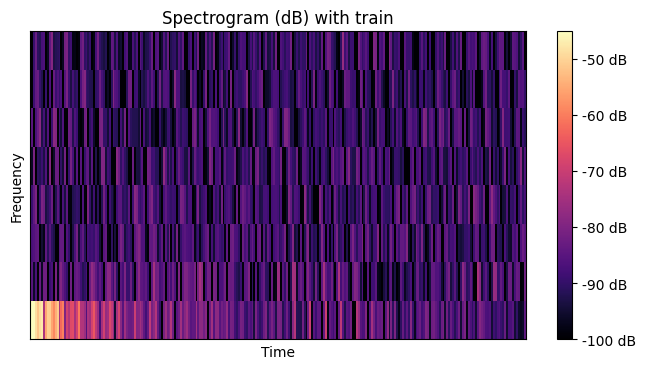

In [ ]:
log_stft_plot (log_stft_w_train, 10, (8,4), 500, "Spectrogram (dB) with train")

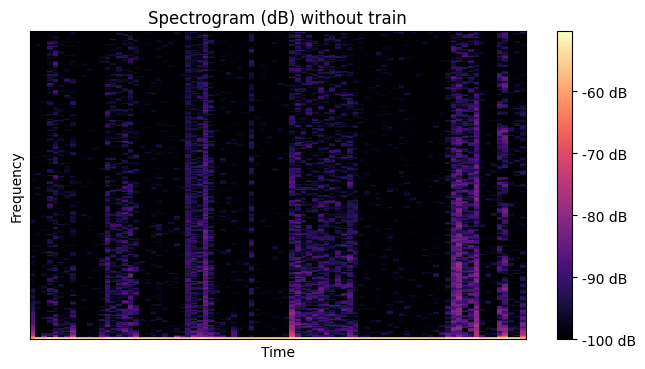

In [ ]:
log_stft_plot (log_stft_wo_train, 10, (8,4), 500, "Spectrogram (dB) without train")

In [ ]:
Y1 = np.vstack ((Y_w_train.reshape (Y_w_train.shape[0], 1), Y_wo_train.reshape (Y_wo_train.shape[0], 1)))
Y2 = np.vstack ((np.full((8,1), 1), np.full((84,1), 0)))
Y3 = np.vstack ((np.full((7,1), 1), np.full((94,1), 0)))
X1 = np.vstack ((cwt_w_train, cwt_wo_train))
X2 = np.vstack ((log_stft_w_train.reshape (log_stft_w_train.shape[1], log_stft_w_train.shape[0]), log_stft_wo_train.reshape (log_stft_wo_train.shape[1], log_stft_wo_train.shape[0])))
X3 = np.vstack ((spectrum_w_train.reshape (spectrum_w_train.shape[1], spectrum_w_train.shape[0]), spectrum_wo_train.reshape (spectrum_wo_train.shape[1], spectrum_wo_train.shape[0])))
print (X1.shape, X2.shape, X3.shape)
lb = LabelBinarizer()
enc = OneHotEncoder ()

from sklearn.model_selection import train_test_split
#X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, lb.fit_transform (Y1), test_size=0.33, random_state=42)
#X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, lb.fit_transform (Y2), test_size=0.33, random_state=42)
#X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3, lb.fit_transform (Y3), test_size=0.33, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, enc.fit_transform (Y1).toarray(), test_size=0.33, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, enc.fit_transform (Y2).toarray(), test_size=0.33, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3, enc.fit_transform (Y3).toarray(), test_size=0.33, random_state=42)

def reshape (train, test):
  x_train = train.reshape(train.shape[0], 1, train.shape[1])
  x_test = test.reshape(test.shape[0], 1, test.shape[1])
  return x_train, x_test


def oned_model (X):
    model = keras.Sequential ()
    model.add (keras.Input (shape = (X.shape[1], X.shape[2])))
    model.add (Dense(4))
    model.add (LSTM (4))
    model.add(Dense(2, activation='softmax'))
    return model

(22881, 33) (92, 257) (101, 129)


In [ ]:
cwt_train, cwt_test = reshape (X_train_3, X_test_3)
model2 = oned_model (cwt_train)
model2.summary ()
model2.compile (optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
hisory = model2.fit (cwt_train, y_train_3, epochs=50, verbose = 1, validation_split= 0.2)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 1, 4)              520       
                                                                 
 lstm_25 (LSTM)              (None, 4)                 144       
                                                                 
 dense_51 (Dense)            (None, 2)                 10        
                                                                 
Total params: 674 (2.63 KB)
Trainable params: 674 (2.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 4s 703ms/step - loss: 0.6929 - accuracy: 0.9245 - mse: 0.2497 - val_loss: 0.6919 - val_accuracy: 0.9286 - val_mse: 0.2488
Epoch 2/50
2/2 [==============================] - 0s 49ms/step - loss: 0.6917 - accuracy: 0.9245 - mse: 0.2486 - va

In [ ]:
y_pred_1 = model2.predict (cwt_test)
y_pred_2 = model2.predict (cwt_train)
print ("Test precision", sklearn.metrics.precision_score(y_test_3, np.round(y_pred_1), average = 'weighted'))
print ("Test recall", sklearn.metrics.recall_score(y_test_3, np.round(y_pred_1), average = 'weighted'))
print ("Test F1", sklearn.metrics.f1_score(y_test_3, np.round(y_pred_1), average = 'weighted'))

print ("Train precision", sklearn.metrics.precision_score(y_train_3, np.round(y_pred_2), average = 'weighted'))
print ("Train recall", sklearn.metrics.recall_score(y_train_3, np.round(y_pred_2), average = 'weighted'))
print ("Train F1", sklearn.metrics.f1_score(y_train_3, np.round(y_pred_2), average = 'weighted'))


3/3 [==============================] - 0s 5ms/step
Test precision 0.8858131487889274
Test recall 0.9411764705882353
Test F1 0.912655971479501
Train precision 0.8563154377366897
Train recall 0.9253731343283582
Train F1 0.889505958579197


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


dict_keys(['loss', 'accuracy', 'mse', 'val_loss', 'val_accuracy', 'val_mse'])


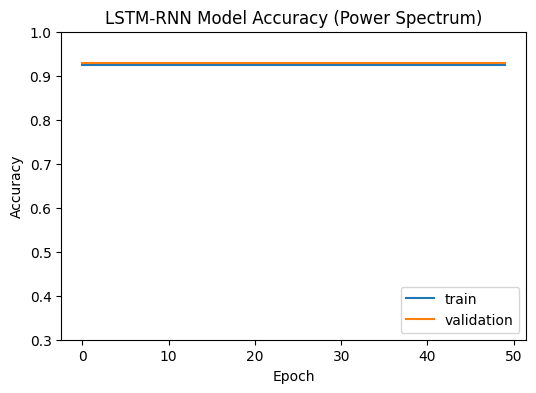

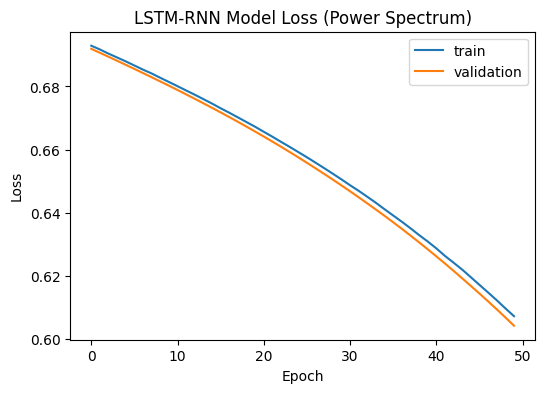

In [ ]:
print(hisory.history.keys())

plt.figure (figsize = (6,4))
plt.plot(hisory.history['accuracy'])
plt.plot(hisory.history['val_accuracy'])
plt.title('LSTM-RNN Model Accuracy (Power Spectrum)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim (0.3, 1.0)
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.figure (figsize = (6,4))
plt.plot(hisory.history['loss'])
plt.plot(hisory.history['val_loss'])
plt.title('LSTM-RNN Model Loss (Power Spectrum)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


Decision Trees and SVM

In [ ]:
def decision_tree (x, y):
  from sklearn import tree
  from sklearn.model_selection import GridSearchCV
  tree_ = tree.DecisionTreeClassifier(class_weight={1: 5})
  parameters = {'criterion': ('gini', 'entropy', 'log_loss'), 'max_depth': [2,8]}
  clf = GridSearchCV (tree_, parameters)
  clf.fit (x,y)
  print ('Best parameters:',clf.best_params_, 'Score:',clf.score (x,y), 'Best estimator:',clf.best_estimator_)
  return clf.best_estimator_


def precision_recall_f1 (y_true, y_pred, dataset):
  print (dataset, 'Precision', sklearn.metrics.precision_score (y_true, y_pred))
  print (dataset, 'Recall', sklearn.metrics.recall_score (y_true, y_pred))
  print (dataset, 'F1', sklearn.metrics.f1_score (y_true, y_pred))

def svc_ (x, y):
  from sklearn.svm import SVC
  from sklearn.model_selection import GridSearchCV
  svc = SVC(class_weight={1: 5})
  parameters = {'kernel':('linear', 'rbf', 'sigmoid'), 'gamma':('scale', 'auto'), 'C': [1,10]}
  clf = GridSearchCV (svc, parameters)
  clf.fit (x, y)
  print ('Best parameters:',clf.best_params_, 'Score:',clf.score (x, y), 'Best estimator:', clf.best_estimator_)
  return clf.best_estimator_


In [ ]:
cwt_tree = decision_tree (X_train_1, y_train_1)
precision_recall_f1 (y_test_1, cwt_tree.predict (X_test_1), 'Test')
precision_recall_f1 (y_train_1, cwt_tree.predict (X_train_1), 'Train')

log_stft_tree = decision_tree (X_train_2, y_train_2)
precision_recall_f1 (y_test_2, log_stft_tree.predict (X_test_2), 'Test')
precision_recall_f1 (y_train_2, log_stft_tree.predict (X_train_2), 'Train')

spectrum_tree = decision_tree (X_train_3, y_train_3)
precision_recall_f1 (y_test_3, spectrum_tree.predict (X_test_3), 'Test')
precision_recall_f1 (y_train_3, spectrum_tree.predict (X_train_3), 'Train')

Best parameters: {'criterion': 'gini', 'max_depth': 8} Score: 0.9426614481409002 Best estimator: DecisionTreeClassifier(class_weight={1: 5}, max_depth=8)
Test Precision 0.4392905866302865
Test Recall 0.6338582677165354
Test F1 0.5189363416599516
Train Precision 0.5758495145631068
Train Recall 0.8405668733392383
Train F1 0.6834713719841555
Best parameters: {'criterion': 'gini', 'max_depth': 2} Score: 1.0 Best estimator: DecisionTreeClassifier(class_weight={1: 5}, max_depth=2)
Test Precision 1.0
Test Recall 0.5
Test F1 0.6666666666666666
Train Precision 1.0
Train Recall 1.0
Train F1 1.0
Best parameters: {'criterion': 'gini', 'max_depth': 2} Score: 0.9402985074626866 Best estimator: DecisionTreeClassifier(class_weight={1: 5}, max_depth=2)
Test Precision 0.0
Test Recall 0.0
Test F1 0.0
Train Precision 1.0
Train Recall 0.2
Train F1 0.33333333333333337


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# DOT data
dot_data = sklearn.tree.export_graphviz(log_stft_tree, out_file=None, feature_names = np.full (257, 'Log STFT (dB)'), class_names = np.array(['No Train', 'Train']) , filled=True)
# Draw graph
graph = graphviz.Source(dot_data)
graph

In [ ]:
cwt_svc = svc_ (X_train_1, y_train_1.reshape(15330, ))
precision_recall_f1 (y_test_1.reshape(7551, ), cwt_svc.predict (X_test_1), 'Test')
precision_recall_f1 (y_train_1.reshape(15330, ), cwt_svc.predict (X_train_1), 'Train')

log_stft_svc = svc_ (X_train_2, y_train_2.reshape(61, ))
precision_recall_f1 (y_test_2.reshape(31, ), log_stft_svc.predict (X_test_2), 'Test')
precision_recall_f1 (y_train_2.reshape(61, ), log_stft_svc.predict (X_train_2), 'Train')

spectrum_svc = svc_ (X_train_3, y_train_3.reshape(67,))
precision_recall_f1 (y_test_3.reshape(34, ), spectrum_svc.predict (X_test_3), 'Test')
precision_recall_f1 (y_train_3.reshape(67, ), spectrum_svc.predict (X_train_3), 'Train')

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} Score: 0.9426614481409002 Best estimator: SVC(C=10, class_weight={1: 5})
Test Precision 0.5051094890510949
Test Recall 0.6811023622047244
Test F1 0.5800502933780386
Train Precision 0.5800256081946222
Train Recall 0.8024800708591674
Train F1 0.673355629877369
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} Score: 1.0 Best estimator: SVC(C=1, class_weight={1: 5})
Test Precision 1.0
Test Recall 1.0
Test F1 1.0
Train Precision 1.0
Train Recall 1.0
Train F1 1.0
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} Score: 1.0 Best estimator: SVC(C=1, class_weight={1: 5})
Test Precision 1.0
Test Recall 1.0
Test F1 1.0
Train Precision 1.0
Train Recall 1.0
Train F1 1.0


log_stft confusion matrix: [[29  0]
 [ 0  2]]
power spectrum confusion matrix: [[32  0]
 [ 0  2]]
